## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [3]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  positive   
1  neutral    
2  positive   
3  neutral    
4  neutral    

                                                                                                                                     Headline  
0  Earnings per share for January-June 2010 were EUR0 .30 , an increase of 20 % year-on-year EUR0 .25 .                                        
1  Exel 's board of directors will propose a dividend of 0.2 euro $ 0.3 per share for 2006 at the annual general meeting on April 19 , 2007 .  
2  Orders received grew by 55 % year-on-year to EUR732m .                                                                                      
3  Deliveries are to start later in 2010 , and the volume will increase in the years 2011-2012 .                                               
4  The most popular paper by far was Kesko 's loyal customer magazine Pirkka with 2,462,000 readers .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [4]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

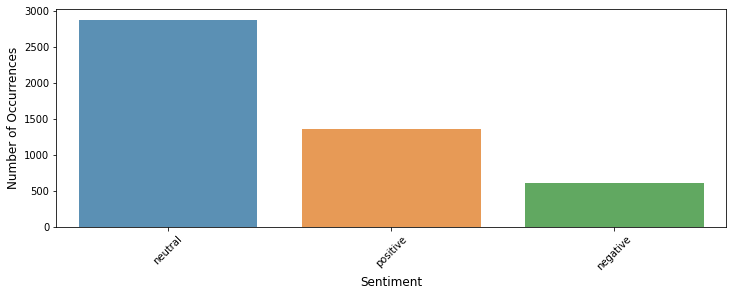

In [5]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [6]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [7]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  0           
1  1           
2  0           
3  1           
4  1           
5  1           
6  1           
7  1           
8  1           
9  0           

                                                                                                                                                                                                               Headline  
0  Earnings per share for January-June 2010 were EUR0 .30 , an increase of 20 % year-on-year EUR0 .25 .                                                                                                                  
1  Exel 's board of directors will propose a dividend of 0.2 euro $ 0.3 per share for 2006 at the annual general meeting on April 19 , 2007 .                                                                            
2  Orders received grew by 55 % year-on-year to EUR732m .                                                                                                                                                                
3  Deliveries are to start later in 2010 , and the volume will increase in the years 2011-2012 .                                                                                                                         
4  The most popular paper by far was Kesko 's loyal customer magazine Pirkka with 2,462,000 readers .                                                                                                                    
5  The Network Test Business is part of Elektrobit 's Test and Automation Business Segment and employs 39 people in Finland and 22 people abroad , mainly in the US and Asia .                                           
6  Koduextra is operating a retail chain of 11 stores , controlled by Finnish Non-Food Center KY , Rukax OY , and Scan-Tukka OY .                                                                                        
7  Following its strategy , Tikkurila has established a fully-owned sales company TOO Tikkurila in Almaty , Kazakhstan , for marketing decorative paints under the Finnish Tikkurila brand and the Russian Teks brand .  
8  Rimi supermarket is the key customer in Magistral center .                                                                                                                                                            
9  Finlan 's listed food industry company HKScan Group controlled companies in the Baltics improved revenues by EUR 3.5 mn to EUR 160.4 mn in 2010 from EUR 156.9 mn in the year before .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [8]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [9]:
#make a new column for clean headlines and then other columns for different version of data

In [10]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  0           
3  1           
4  1           

                                                                                                 Headline  
0  earnings per share january-june 2010 eur0 .30 increase 20 year-on-year eur0 .25                         
1  exel board directors propose dividend 0.2 euro 0.3 per share 2006 annual general meeting april 19 2007  
2  orders received grew 55 year-on-year eur732m                                                            
3  deliveries start later 2010 volume increase years 2011-2012                                             
4  popular paper far kesko loyal customer magazine pirkka 2,462,000 readers

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [13]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  0           
3  1           
4  1           

                                                                                                 Headline  \
0  earnings per share january-june 2010 eur0 .30 increase 20 year-on-year eur0 .25                          
1  exel board directors propose dividend 0.2 euro 0.3 per share 2006 annual general meeting april 19 2007   
2  orders received grew 55 year-on-year eur732m                                                             
3  deliveries start later 2010 volume increase years 2011-2012                                              
4  popular paper far kesko loyal customer magazine pirkka 2,462,000 readers                                 

                                                                                          Headline_Lemma  
0  earnings per share january-june 2010 eur0 .30 increase 20 year-on-year eur0 .25                        
1  exel board director propose dividend 0.2 euro 0.3 per share 2006 annual general meeting april 19 2007  
2  order receive grow 55 year-on-year eur732m                                                             
3  delivery start later 2010 volume increase year 2011-2012                                               
4  popular paper far kesko loyal customer magazine pirkka 2,462,000 reader

WordCloud to see the commonly used words

In [14]:
#!pip install wordcloud

In [15]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [16]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


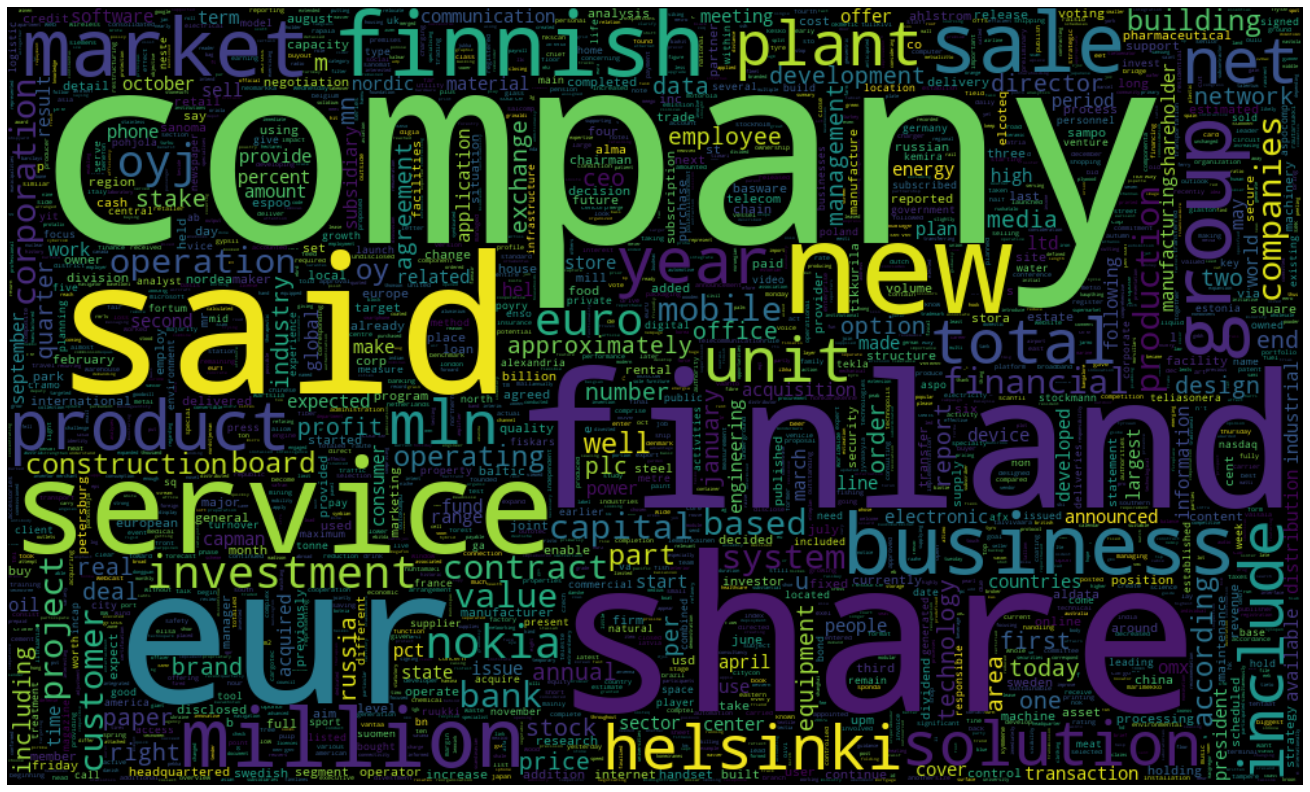

Negative Sentiment Wordcloud:


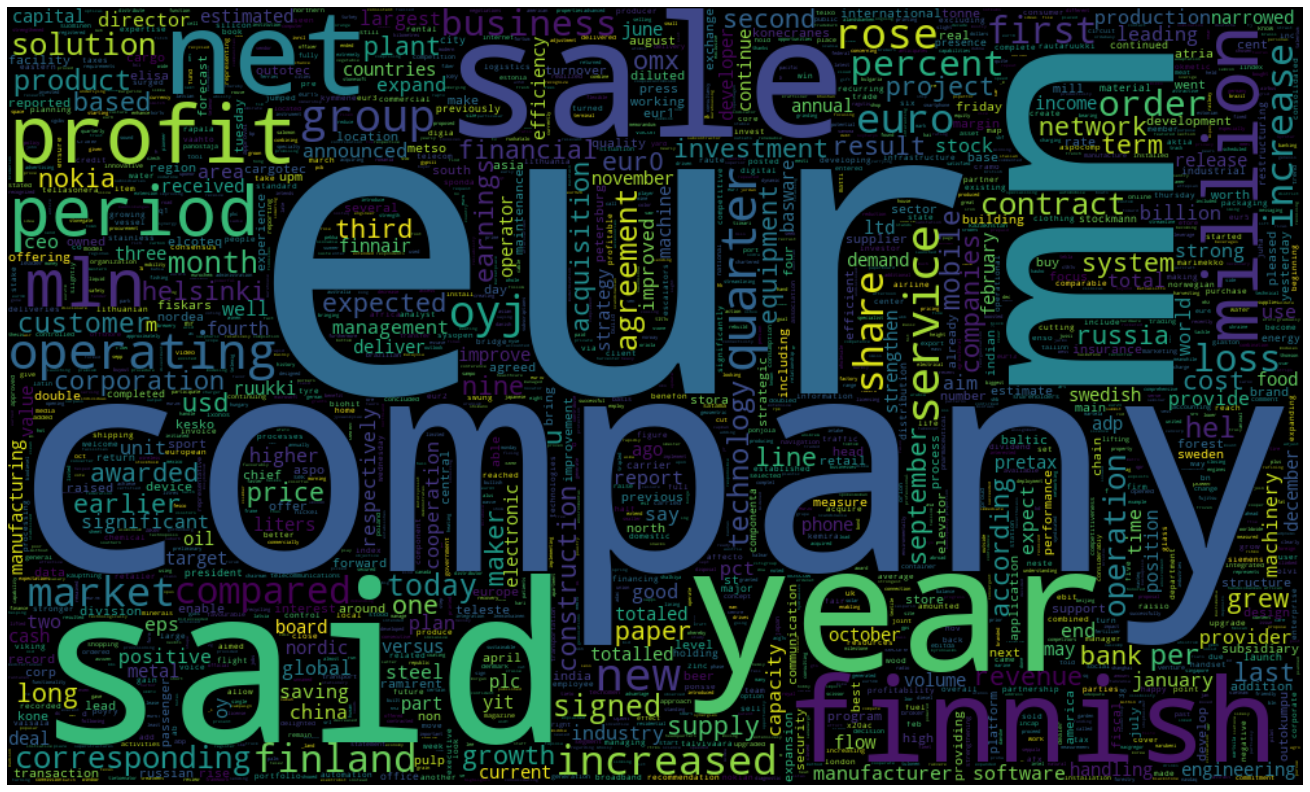

In [17]:
show_wordclouds()

Positive Sentiment Wordcloud:


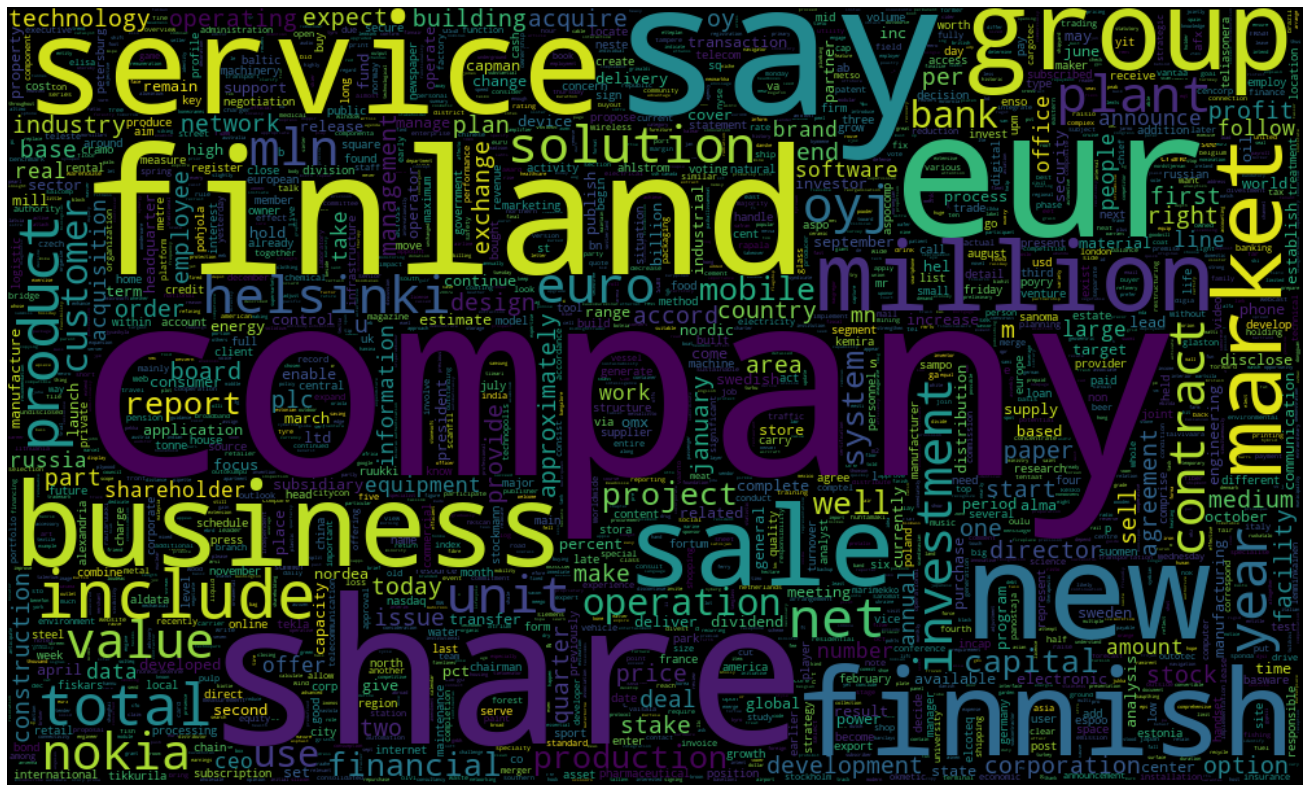

Negative Sentiment Wordcloud:


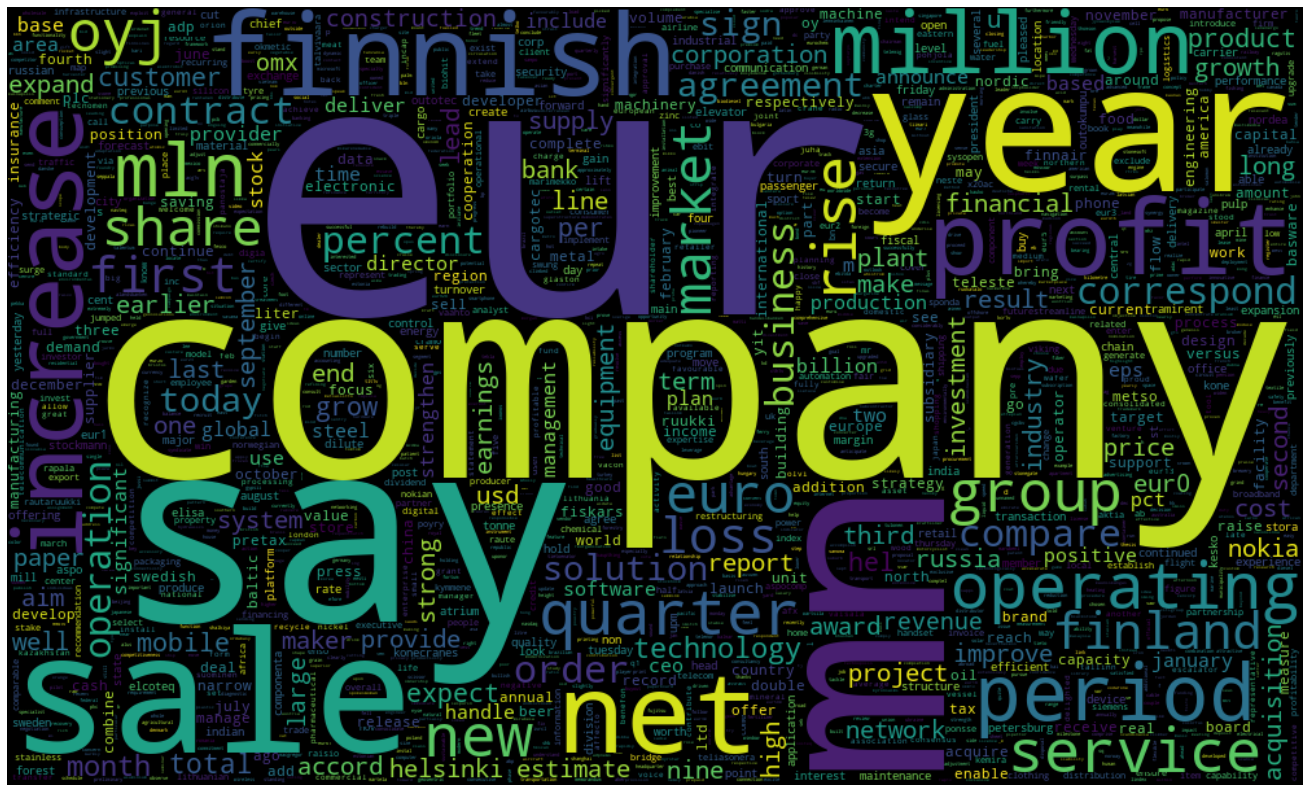

In [18]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [19]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [20]:
df.head()

Sentiment  \
0  0           
1  1           
2  0           
3  1           
4  1           

                                                                                                 Headline  \
0  earnings per share january-june 2010 eur0 .30 increase 20 year-on-year eur0 .25                          
1  exel board directors propose dividend 0.2 euro 0.3 per share 2006 annual general meeting april 19 2007   
2  orders received grew 55 year-on-year eur732m                                                             
3  deliveries start later 2010 volume increase years 2011-2012                                              
4  popular paper far kesko loyal customer magazine pirkka 2,462,000 readers                                 

                                                                                          Headline_Lemma  \
0  earnings per share january-june 2010 eur0 .30 increase 20 year-on-year eur0 .25                         
1  exel board director propose dividend 0.2 euro 0.3 per share 2006 annual general meeting april 19 2007   
2  order receive grow 55 year-on-year eur732m                                                              
3  delivery start later 2010 volume increase year 2011-2012                                                
4  popular paper far kesko loyal customer magazine pirkka 2,462,000 reader                                 

                                                                                          Headline_soup  
0  earnings per share january-june 2010 eur0 .30 increase 20 year-on-year eur0 .25                       
1  eel board director propose dividend 0.2 euro 0.3 per share 2006 annual general meeting april 19 2007  
2  order receive grow 55 year-on-year eur732m                                                            
3  delivery start later 2010 volume increase year 2011-2012                                              
4  popular paper far kesko loyal customer magazine pirkka 2,462,000 reader

#### Counter

In [21]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [22]:
text = df.Headline_Lemma
counter = counter_word(text)

In [23]:
len(counter)

10088

In [24]:
num_words = len(counter)

### Train/Test Split

In [25]:
# headlines = []
# labels = []

# for row in range(len(df)):
#     headlines.append(df['Headline_soup'][row])
#     labels.append(df['Sentiment'][row])

In [26]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(
    df['Headline_soup'], df['Sentiment'], test_size=0.2 , random_state=42)

In [27]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [28]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

432     make matter difficult company say grapple high oil gas price push cost energy raw material transportation
3071    carrier handset maker spin positive event raise interest higher-end phone pricier data plan              
289     hk ruokatalo target know consumer                                                                        
Name: Headline_soup, dtype: object

432     2
3071    0
289     1
Name: Sentiment, dtype: int64

In [29]:
training_labels

432     2
3071    0
289     1
2588    2
4121    1
       ..
4426    0
466     0
3092    1
3772    0
860     1
Name: Sentiment, Length: 3876, dtype: int64

In [30]:
testing_labels

3207    2
1684    0
1044    1
4145    1
1538    1
       ..
3691    0
1507    1
1126    1
180     0
1215    2
Name: Sentiment, Length: 970, dtype: int64

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [31]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [32]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [33]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [34]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [35]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [36]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [37]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
# training_padded = np.array(training_padded)
# training_labels = np.array(training_labels)
# testing_padded = np.array(testing_padded)
# testing_labels = np.array(testing_labels)

In [38]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 473 141  12 871  61 201  45]

The actual headline:
 delivery start later 2010 volume increase year 2011-2012

Label:
 1


In [39]:
# train
#train_tagged.values

In [40]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([0., 0., 1.], dtype=float32)

### Model 1 (Hidden Layer)

In [41]:
# embedding_dim = 100

# model = Sequential()
# model.add(Embedding(num_words, embedding_dim, input_length=64))
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2)) # Optional Regularization
# model.add(Dense(3, activation='sigmoid'))

# # Slower learning rate worked better as it kept the learning more stable
# #opt = keras.optimizers.Adam(lr=0.0001)
# model.compile(loss='categorical_crossentropy',optimizer='adam', 
#               metrics=['accuracy']) # Orig code

In [42]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [43]:
#results.history.keys()

In [44]:



def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    
#     history = results.history
#     plt.figure()
#     plt.plot(history['val_loss'])
#     plt.plot(history['loss'])
#     plt.legend(['val_loss', 'loss'])
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.show()
    
#     plt.figure()
#     plt.plot(history['val_accuracy'])
#     plt.plot(history['accuracy'])
#     plt.legend(['val_acc', 'acc'])
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.show()
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [45]:
#model_metrics(model)

In [46]:
#test_headlines()

### Model 2 (LSTM):

In [91]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1008800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [93]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
146/146 [==============================] - 9s 59ms/step - loss: 0.8730 - accuracy: 0.6216 - val_loss: 0.7129 - val_accuracy: 0.7036
Epoch 2/50
146/146 [==============================] - 9s 59ms/step - loss: 0.5727 - accuracy: 0.7557 - val_loss: 0.7371 - val_accuracy: 0.7216
Epoch 3/50
146/146 [==============================] - 9s 62ms/step - loss: 0.2874 - accuracy: 0.8945 - val_loss: 0.8554 - val_accuracy: 0.6392
Epoch 4/50
146/146 [==============================] - 8s 57ms/step - loss: 0.1417 - accuracy: 0.9558 - val_loss: 1.0432 - val_accuracy: 0.6778
Epoch 5/50
146/146 [==============================] - 8s 56ms/step - loss: 0.0892 - accuracy: 0.9736 - val_loss: 1.1801 - val_accuracy: 0.6727
Epoch 6/50
146/146 [==============================] - 8s 55ms/step - loss: 0.0654 - accuracy: 0.9805 - val_loss: 1.2729 - val_accuracy: 0.6649
Epoch 00006: early stopping


In [102]:
y_hat = model.predict(testing_padded)
predicted = y_hat.argmax(axis=1)
true = testing_labels_ohe.argmax(axis=1)

In [104]:
import sklearn.metrics as metrics


print(metrics.classification_report(true,predicted))

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       274
           1       0.76      0.85      0.81       583
           2       0.63      0.42      0.51       113

    accuracy                           0.72       970
   macro avg       0.67      0.61      0.63       970
weighted avg       0.71      0.72      0.71       970



In [90]:
#model_metrics(model)

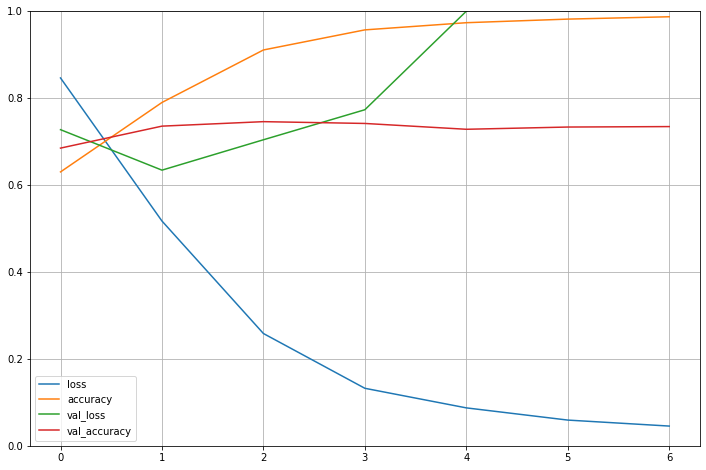

In [51]:
model_eval(history)

In [52]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [53]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    #validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
122/122 [==============================] - 6s 48ms/step - loss: 0.9284 - accuracy: 0.5947 - val_loss: 0.8307 - val_accuracy: 0.6412
Epoch 2/50
122/122 [==============================] - 5s 38ms/step - loss: 0.7175 - accuracy: 0.6718 - val_loss: 0.7118 - val_accuracy: 0.6856
Epoch 3/50
122/122 [==============================] - 5s 37ms/step - loss: 0.5457 - accuracy: 0.7472 - val_loss: 0.7162 - val_accuracy: 0.7000
Epoch 4/50
122/122 [==============================] - 5s 38ms/step - loss: 0.3836 - accuracy: 0.8217 - val_loss: 0.7263 - val_accuracy: 0.7165
Epoch 5/50
122/122 [==============================] - 4s 37ms/step - loss: 0.2154 - accuracy: 0.9260 - val_loss: 0.8652 - val_accuracy: 0.7186
Epoch 6/50
122/122 [==============================] - 5s 39ms/step - loss: 0.1250 - accuracy: 0.9592 - val_loss: 1.0069 - val_accuracy: 0.7433
Epoch 7/50
122/122 [==============================] - 6s 49ms/step - loss: 0.0877 - accuracy: 0.9755 - val_loss: 1.0337 - val_accuracy: 0.7361

In [54]:
#model_metrics(model)

ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
#model_eval(history) #seperate val and loss

### Import Headlines To Test Model

In [55]:
import requests

url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/news/list-by-region"

querystring = {"id":"home-v3"}

headers = {
    'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
    'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"title":null,"id":"home-v3","indexBar":{"enabled":true,"quotes":[{"INDU:IND":{"securityType":"Equity Index","symbol":"INDU","country":"United States","currency":"USD","resourceType":"Index","fundamentalDataCurrency":"USD","resourceSubtype":"Equity","region":"AMERICAS","ticker":"indu:ind","tickerName":"INDU:IND","template":"Index","tinyName":"DOW JONES","name":"DOW JONES","watchlist":true,"resourceId":"INDU:IND","eqtIndex":true,"last":"31429.37","netChange":"53.54","lastPriceTime":1612985404,"pctChange1M":"1.07","yearHigh":"31509.87","dayHigh":"31509.87","volume":216596529,"yearLow":"18213.65","dayLow":"31221.32","pctChangeYTD":"2.39","pctChange":"0.17","isOpen":true,"sparkline":{"href":"https://www.bloomberg.com/markets/api/charts/sparkline/INDU:IND.svg?stroke=2"}}},{"SPX:IND":{"securityType":"Equity Index","symbol":"SPX","country":"United States","currency":"USD","resourceType":"Index","fundamentalDataCurrency":"USD","resourceSubtype":"Equity","region":"AMERICAS","ticker":"spx:ind","

In [56]:
response.json()

{'title': None,
 'id': 'home-v3',
 'indexBar': {'enabled': True,
  'quotes': [{'INDU:IND': {'securityType': 'Equity Index',
     'symbol': 'INDU',
     'country': 'United States',
     'currency': 'USD',
     'resourceType': 'Index',
     'fundamentalDataCurrency': 'USD',
     'resourceSubtype': 'Equity',
     'region': 'AMERICAS',
     'ticker': 'indu:ind',
     'tickerName': 'INDU:IND',
     'template': 'Index',
     'tinyName': 'DOW JONES',
     'name': 'DOW JONES',
     'watchlist': True,
     'resourceId': 'INDU:IND',
     'eqtIndex': True,
     'last': '31429.37',
     'netChange': '53.54',
     'lastPriceTime': 1612985404,
     'pctChange1M': '1.07',
     'yearHigh': '31509.87',
     'dayHigh': '31509.87',
     'volume': 216596529,
     'yearLow': '18213.65',
     'dayLow': '31221.32',
     'pctChangeYTD': '2.39',
     'pctChange': '0.17',
     'isOpen': True,
     'sparkline': {'href': 'https://www.bloomberg.com/markets/api/charts/sparkline/INDU:IND.svg?stroke=2'}}},
   {'SPX:I

In [58]:
results = response.json()
results.keys()

dict_keys(['title', 'id', 'indexBar', 'modules'])

In [74]:

modules = results['modules']
len(modules)

21

Loops to get more stories

In [85]:
titles = []
dates = []
for module in modules:
    for story in module['stories']:
        titles.append(story['title'])
        dates.append(story['id'])

In [87]:
results_df = pd.DataFrame({'id': dates, 'titles': titles})
results_df

id  \
0   2021-02-10/house-managers-get-to-present-their-case-impeachment-update       
1   2021-02-10/covid-variant-gains-momentum-in-u-s-as-total-cases-plummet        
2   2021-02-09/global-stock-rally-stalls-dollar-retreats-markets-wrap            
3   2021-02-10/powell-says-full-jobs-recovery-will-require-more-government-aid   
4   2021-02-10/citadel-s-griffin-expected-to-testify-at-house-gamestop-hearing   
..                                                                         ...   
74  2021-02-10/evergrande-unveils-three-more-pure-electric-cars-in-ev-push       
75  2021-02-10/powell-says-full-jobs-recovery-will-require-more-government-aid   
76  J3nh49r_TqSVxPUcMG4tug                                                       
77  vTvt7P_oSvSqG9k0$jbv8A                                                       
78  GcHesIm6R3mkXPvcz58QVA                                                       

                                                                 titles  
0   Democrats Say Trump ‘Lit the Match’ of Mob: Impeachment Update       
1   Covid Variant Gains Momentum in U.S. as Total Cases Plummet          
2   Stocks Fluctuate; Treasuries Gain on Subdued CPI: Markets Wrap       
3   Powell Urges ‘Society-Wide’ Push to Deliver Full Employment          
4   Citadel’s Ken Griffin Expected to Testify at House GameStop Hearing  
..                                                                  ...  
74  Evergrande Unveils Three More Pure Electric Cars in EV Push          
75  Powell Urges ‘Society-Wide’ Push to Deliver Full Employment          
76  Unity Fading Away as Republicans Blast Biden Stimulus Plan           
77  The Fed May Not Tighten Until 2022, Says Julian Emanuel              
78  Incoming Chamber CEO Sees Real Hope of Reaching New Stimulus Deal    

[79 rows x 2 columns]

In [88]:
results_df.to_csv('bloomberg_news.csv', index=False)

In [89]:
pd.read_csv('bloomberg_news.csv')

id  \
0   2021-02-10/house-managers-get-to-present-their-case-impeachment-update       
1   2021-02-10/covid-variant-gains-momentum-in-u-s-as-total-cases-plummet        
2   2021-02-09/global-stock-rally-stalls-dollar-retreats-markets-wrap            
3   2021-02-10/powell-says-full-jobs-recovery-will-require-more-government-aid   
4   2021-02-10/citadel-s-griffin-expected-to-testify-at-house-gamestop-hearing   
..                                                                         ...   
74  2021-02-10/evergrande-unveils-three-more-pure-electric-cars-in-ev-push       
75  2021-02-10/powell-says-full-jobs-recovery-will-require-more-government-aid   
76  J3nh49r_TqSVxPUcMG4tug                                                       
77  vTvt7P_oSvSqG9k0$jbv8A                                                       
78  GcHesIm6R3mkXPvcz58QVA                                                       

                                                                 titles  
0   Democrats Say Trump ‘Lit the Match’ of Mob: Impeachment Update       
1   Covid Variant Gains Momentum in U.S. as Total Cases Plummet          
2   Stocks Fluctuate; Treasuries Gain on Subdued CPI: Markets Wrap       
3   Powell Urges ‘Society-Wide’ Push to Deliver Full Employment          
4   Citadel’s Ken Griffin Expected to Testify at House GameStop Hearing  
..                                                                  ...  
74  Evergrande Unveils Three More Pure Electric Cars in EV Push          
75  Powell Urges ‘Society-Wide’ Push to Deliver Full Employment          
76  Unity Fading Away as Republicans Blast Biden Stimulus Plan           
77  The Fed May Not Tighten Until 2022, Says Julian Emanuel              
78  Incoming Chamber CEO Sees Real Hope of Reaching New Stimulus Deal    

[79 rows x 2 columns]

In [79]:
titles

['Democrats Say Trump ‘Lit the Match’ of Mob: Impeachment Update',
 'Covid Variant Gains Momentum in U.S. as Total Cases Plummet',
 'Stocks Fluctuate; Treasuries Gain on Subdued CPI: Markets Wrap',
 'Powell Urges ‘Society-Wide’ Push to Deliver Full Employment',
 'Citadel’s Ken Griffin Expected to Testify at House GameStop Hearing',
 'Tilray Surges as Reddit Crowd Turns Its Attention to Pot',
 'Jim Simons Makes Billions While Renaissance Investors Fume at Losses',
 'Bitcoin Is Red Hot. Can It Ever Be Green?',
 'Dylan’s Candy Bar Flagship Store Put Up for Lease After 20 Years',
 'How $1,400 Checks Compare to Previous U.S. Relief Payouts',
 'King of Supply-Chain Finance Expands, and Controversy Follows',
 "When Will Life Return to Normal? In 7\xa0Years at Today's Vaccine Rates",
 'Teva Is in Discussions to Help Make Covid Vaccines, CEO Says',
 'More Than 138\xa0Million Shots Given: Covid-19 Vaccine Tracker',
 'CityLab Daily: What’s Better Than an Electric Car? No Car.',
 'Public Displays 

In [65]:
#module = results['modules'][0]

In [66]:
module.keys()

dict_keys(['id', 'title', 'type', 'mobileMaximum', 'stories'])

In [69]:
len(module['stories'])

1

In [71]:
# story = module['stories'][0]
# story

{'id': '2021-02-10/house-managers-get-to-present-their-case-impeachment-update',
 'internalID': 'QOAE4BT0AFBB01',
 'title': 'Democrats Say Trump ‘Lit the Match’ of Mob: Impeachment Update',
 'summary': '',
 'autoGeneratedSummary': 'Donald Trump’s second impeachment trial is underway in the Senate, with members of the House’s prosecution team delivering their case.',
 'abstract': ['Check here for live updates on the second Trump\xa0impeachment',
  'The trial in the Senate resumed with House managers’ case'],
 'published': 1612954800,
 'updatedAt': 1612983043,
 'wordCount': 2019,
 'secondaryBrands': ['politics'],
 'byline': 'Bloomberg News',
 'shortURL': 'https://www.bloomberg.com/news/articles/2021-02-10/house-managers-get-to-present-their-case-impeachment-update',
 'longURL': 'https://www.bloomberg.com/news/articles/2021-02-10/house-managers-get-to-present-their-case-impeachment-update',
 'primaryCategory': None,
 'primarySite': 'bpol',
 'eyebrowSite': 'bpol',
 'readings': [],
 'image'

In [73]:
story['title']

'Democrats Say Trump ‘Lit the Match’ of Mob: Impeachment Update'

In [ ]:
import http.client

conn = http.client.HTTPSConnection("bloomberg-market-and-financial-news.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
    'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
    }

conn.request("GET", "/market/get-cross-currencies?id=aed%2Caud%2Cbrl%2Ccad%2Cchf%2Ccnh%2Ccny%2Ccop%2Cczk%2Cdkk%2Ceur%2Cgbp%2Chkd%2Chuf%2Cidr%2Cils%2Cinr%2Cjpy%2Ckrw%2Cmxn%2Cmyr%2Cnok%2Cnzd%2Cphp%2Cpln%2Crub%2Csek%2Csgd%2Cthb%2Ctry%2Ctwd%2Cusd%2Czar", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

In [ ]:
data = json.loads(data.decode('utf-8'))
data

In [ ]:
import http.client

conn = http.client.HTTPSConnection("yahoo-finance-low-latency.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
    'x-rapidapi-host': "yahoo-finance-low-latency.p.rapidapi.com"
    }

conn.request("GET", "/v2/finance/news?symbols=AAPL%2CMSFT", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

In [ ]:
# loading a string
data = json.loads(data.decode('utf-8'))
data

In [ ]:
print(data['Content'][1]['title'])

